✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1874s 4s/step - accuracy: 0.5502 - loss: 0.9741 - val_accuracy: 0.7072 - val_loss: 0.6536
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1816s 4s/step - accuracy: 0.6855 - loss: 0.7081 - val_accuracy: 0.7198 - val_loss: 0.6204
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1810s 4s/step - accuracy: 0.7223 - loss: 0.6431 - val_accuracy: 0.7078 - val_loss: 0.6236
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1836s 4s/step - accuracy: 0.7348 - loss: 0.6132 - val_accuracy: 0.7110 - val_loss: 0.6131
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1829s 4s/step - accuracy: 0.7550 - loss: 0.5755 - val_accuracy: 0.7148 - val_loss: 0.6112


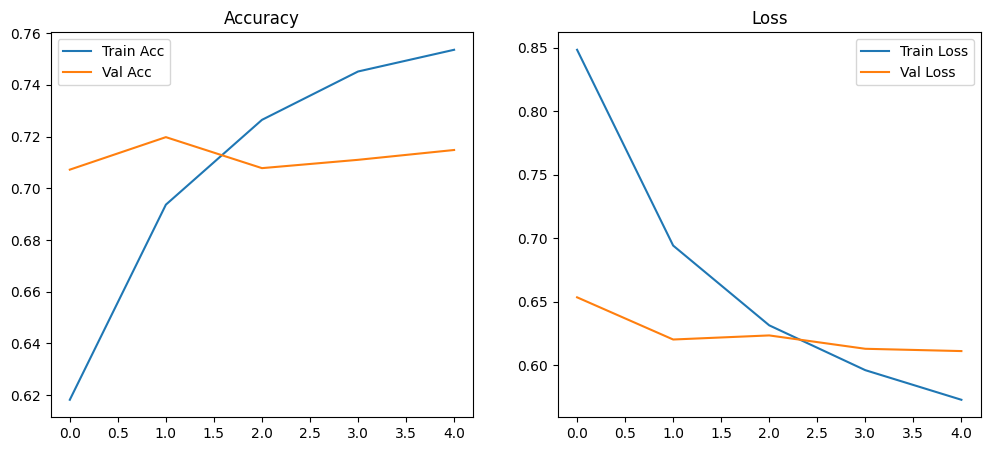

107/107 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.79      0.92      0.85      1378
      2COVID       0.69      0.66      0.68      1518
        3CAP       0.48      0.31      0.38       523

    accuracy                           0.71      3419
   macro avg       0.65      0.63      0.64      3419
weighted avg       0.70      0.71      0.70      3419



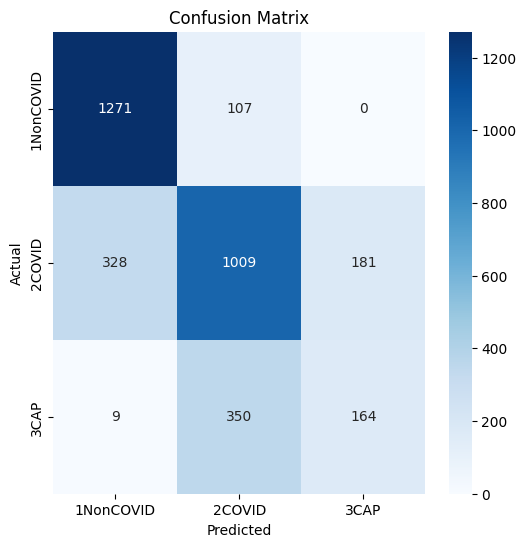

107/107 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.8559 - loss: 0.3819
✅ Final Accuracy: 0.7148
❌ Error Rate: 28.52%


In [ ]:
# 📦 Unzip normalized dataset
import zipfile
with zipfile.ZipFile("normalized_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")
print("✅ Normalized dataset is ready!")

# 🔧 Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset path and setup
data_path = "/content/normalized_dataset/curated_data"
img_size = 224  # ✅ Reduced from 299 for speed
batch_size = 32

# 🔄 Data generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 Model setup
base_model = InceptionV3(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # ✅ Freeze base model to speed up training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋️‍♂️ Train with multiprocessing
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


# 💾 Save model
model.save("InceptionV3_COVID_CT.h5")

# 📉 Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
